# Training for Binary Alert Level Classification using Stacked Models

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# This is from another library only for CTGAN
from ctgan import CTGAN

# From SDV repository
from sdv.lite import SingleTablePreset
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer
from sdv.metadata import SingleTableMetadata

import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

d:\current_progress_07-24-2023 -version2\env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [ ]:
# Load training and test data
train_data_all_raw = pd.read_csv(r'D:\vibration_analysis\data\train_data_all_raw.csv')
test_data_all_raw = pd.read_csv(r'D:\vibration_analysis\data\test_data_all_raw.csv')

In [ ]:
# All of the unique points present in all of the machines of concern (machines to consider)
input_cols = ['1HE_overall_trend', '1HV_overall_trend',
       '1VV_overall_trend', '1AV_overall_trend', '2HE_overall_trend',
       '2HV_overall_trend', '2VV_overall_trend', '2AV_overall_trend',
       '3HE_overall_trend', '3HV_overall_trend', '3VV_overall_trend',
       '3AV_overall_trend', '4HE_overall_trend', '4HV_overall_trend',
       '4VV_overall_trend', '4AV_overall_trend', '5HE_overall_trend',
       '6HE_overall_trend', 'Machine Name', 'Alert Level (Binary)']

In [ ]:
# List of machines to consider
machines_to_consider = [
    'ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER',
    'ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B',
    'AIR COMPRESSORS>GA132 - FAC>Main Air Comp.',
    'AIR COMPRESSORS>GA200 D - FAC',
    'ASSEMBLY>VACUUM MOTOR LINE 2',
    'ASSEMBLY>VACUUM MOTOR LINE 3',
    'ASSEMBLY>VACUUM MOTOR L17 DC'
]

In [ ]:
# Create an empty dictionary to store the X_train, X_test, y_train, and y_test for each machine
train_test_data = {}

# Iterate through each machine
for machine in tqdm(machines_to_consider):
    train_data = pd.DataFrame() # Create empty DataFrame for storage of training data
    test_data = pd.DataFrame() # Create empty DataFrame for storage of test data

    # From test data, get a dataframe consisting of records from the current machine being iterated
    test_grp_df = test_data_all_raw.groupby('Machine Name').get_group(machine)
    # Drop columns with all NaN values, meaning the point/feature does not exist on the machine being iterated
    test_grp_df = test_grp_df.dropna(axis=1, how='all')

    # From train data, get a dataframe consisting of records from the current machine being iterated
    train_grp_df = train_data_all_raw.groupby('Machine Name').get_group(machine)
    # Drop columns with all NaN values, meaning the point/feature does not exist on the machine being iterated
    train_grp_df = train_grp_df.dropna(axis=1, how='all')

    # Filter normal records from the filtered train data records
    normal_df = train_grp_df[train_grp_df['Alert Level (Binary)'] == 'Normal']
    # Filter not normal records from the filtered train data records
    not_normal_df = train_grp_df[train_grp_df['Alert Level (Binary)'] == 'Not Normal']

    # Detect metadata from DataFrame needed for synthesizers
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=not_normal_df)

    # For more synthesizers (data gen for tabular data): https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers
    # enfore_min_max_values=False to not limit the values of synthesized records based on the original records
    synthesizer_not_normal = CopulaGANSynthesizer(metadata=metadata, epochs=500)
    # synthesizer_not_normal = GaussianCopulaSynthesizer(metadata=metadata, enforce_min_max_values=False)
    # Fit the synthesizer to the not normal records from train data
    synthesizer_not_normal.fit(not_normal_df)
    # Generate samples: Length of Normal Records DF - Length of Not Normal Records DF
    not_normal_samples = synthesizer_not_normal.sample(len(normal_df) - len(not_normal_df))
    # Add 'synthetic?' column to identify which records are synthetic and original
    # This is not relevant to the training but necessary to know which records are synthetic
    normal_df['synthetic?'] = False
    not_normal_df['synthetic?'] = False
    not_normal_samples['synthetic?'] = True
    # Combine the three DataFrames to make the training data for the current machine being iterated (Drop Machine Name column)
    # By adding synthetic not normal records, the training support for each class would be balanced
    train_data = pd.concat([normal_df, not_normal_df, not_normal_samples], axis=0).drop(['Machine Name'], axis=1)

    # Check for duplicates
    print(f"Duplicates: {(train_data.duplicated().sum())}")

    # Create the test data for the current machine being iterated (no synthetic data for this)
    test_data = pd.concat([test_data, test_grp_df], axis=0).drop(['Machine Name'], axis=1)

    # Check the shape of train and test data
    print(train_data.shape, test_data.shape)

    # Define X_train, X_test, y_train, and y_test
    X_train = train_data.drop('Alert Level (Binary)', axis=1)
    y_train = train_data['Alert Level (Binary)'].apply(lambda x: 0 if x == 'Normal' else 1) # 0=Normal; 1=Not Normal
    X_test = test_data.drop('Alert Level (Binary)', axis=1)
    y_test = test_data['Alert Level (Binary)'].apply(lambda x: 0 if x == 'Normal' else 1) # 0=Normal; 1=Not Normal

    # Create a dictionary key,value pair for the new machine if non-existent
    if train_test_data.get(machine) is None:
        train_test_data[machine] = {}

    # Add the correspding X_train, X_test, y_train, and y_test for the current machine in the dictionary
    train_test_data[machine]['X_train'] = X_train
    train_test_data[machine]['y_train'] = y_train
    train_test_data[machine]['X_test'] = X_test
    train_test_data[machine]['y_test'] = y_test

 14%|█▍        | 1/7 [00:33<03:19, 33.18s/it]

Duplicates: 0
(146, 18) (8, 17)


 29%|██▊       | 2/7 [01:08<02:51, 34.31s/it]

Duplicates: 0
(102, 18) (5, 17)


 43%|████▎     | 3/7 [01:41<02:15, 33.77s/it]

Duplicates: 0
(42, 14) (6, 13)


 57%|█████▋    | 4/7 [02:15<01:41, 33.74s/it]

Duplicates: 0
(28, 14) (11, 13)


 71%|███████▏  | 5/7 [02:46<01:05, 32.92s/it]

Duplicates: 0
(36, 10) (14, 9)


 86%|████████▌ | 6/7 [03:17<00:32, 32.12s/it]

Duplicates: 0
(38, 10) (13, 9)


100%|██████████| 7/7 [03:48<00:00, 32.59s/it]

Duplicates: 0
(34, 10) (12, 9)


In [ ]:
# Checking for negative values present in each row
# There is no negative overall trend value
for machine in train_test_data.keys():
    sample_df = train_test_data[machine]['X_train']
    print(f'{machine}: {len(sample_df[sample_df.lt(0).any(axis=1)])}')

ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER: 0
ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B: 0
AIR COMPRESSORS>GA132 - FAC>Main Air Comp.: 0
AIR COMPRESSORS>GA200 D - FAC: 0
ASSEMBLY>VACUUM MOTOR LINE 2: 0
ASSEMBLY>VACUUM MOTOR LINE 3: 0
ASSEMBLY>VACUUM MOTOR L17 DC: 0


In [ ]:
# Check the shape of train and test data for each machine
for machine in machines_to_consider:
    print(f'\n{machine}')
    print('Training Data Shape: {} {}'.format(train_test_data[machine]['X_train'].shape, train_test_data[machine]['y_train'].shape))
    print('Test Data Shape: {} {}'.format(train_test_data[machine]['X_test'].shape, train_test_data[machine]['y_test'].shape))


ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER
Training Data Shape: (146, 17) (146,)
Test Data Shape: (8, 16) (8,)

ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B
Training Data Shape: (102, 17) (102,)
Test Data Shape: (5, 16) (5,)

AIR COMPRESSORS>GA132 - FAC>Main Air Comp.
Training Data Shape: (42, 13) (42,)
Test Data Shape: (6, 12) (6,)

AIR COMPRESSORS>GA200 D - FAC
Training Data Shape: (28, 13) (28,)
Test Data Shape: (11, 12) (11,)

ASSEMBLY>VACUUM MOTOR LINE 2
Training Data Shape: (36, 9) (36,)
Test Data Shape: (14, 8) (14,)

ASSEMBLY>VACUUM MOTOR LINE 3
Training Data Shape: (38, 9) (38,)
Test Data Shape: (13, 8) (13,)

ASSEMBLY>VACUUM MOTOR L17 DC
Training Data Shape: (34, 9) (34,)
Test Data Shape: (12, 8) (12,)


In [ ]:
def print_msg_box(msg, indent=1, width=None, title=None):
    """Print message-box with optional title."""
    lines = msg.split('\n')
    space = " " * indent
    if not width:
        width = max(map(len, lines))
    box = f'╔{"═" * (width + indent * 2)}╗\n'  # upper_border
    if title:
        box += f'║{space}{title:<{width}}{space}║\n'  # title
        box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  # underscore
    box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
    box += f'╚{"═" * (width + indent * 2)}╝'  # lower_border
    print(box)

## No Hyperparameter Tuning

╔═════════════════════════════════════════════╗
║ ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER ║
╚═════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

AUC-ROC Score: 1.0


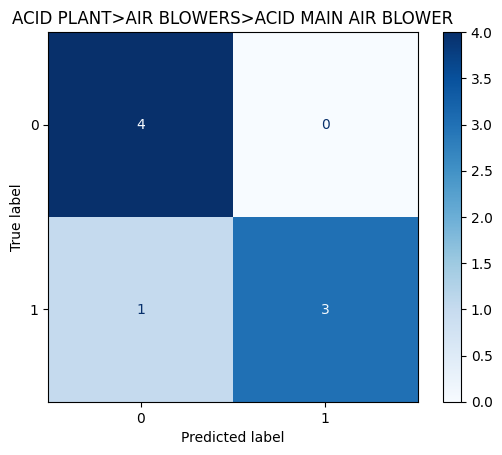

╔═════════════════════════════════════════════════════╗
║ ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B ║
╚═════════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5

AUC-ROC Score: 0.8333333333333334


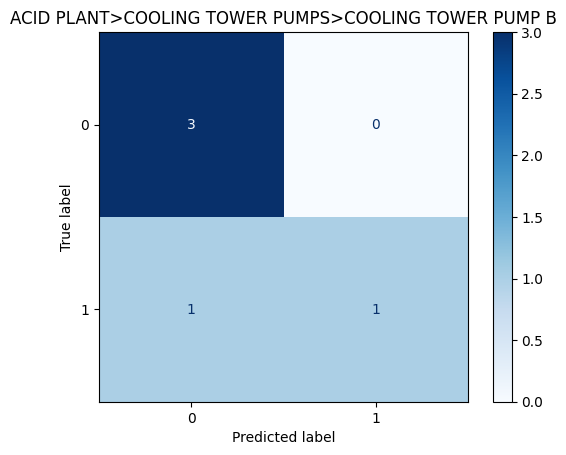

╔════════════════════════════════════════════╗
║ AIR COMPRESSORS>GA132 - FAC>Main Air Comp. ║
╚════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

AUC-ROC Score: 1.0


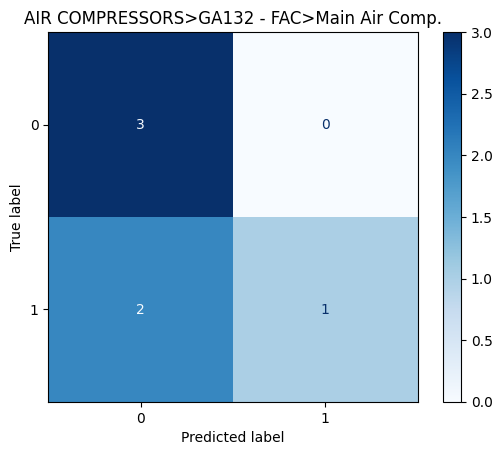

╔═══════════════════════════════╗
║ AIR COMPRESSORS>GA200 D - FAC ║
╚═══════════════════════════════╝
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

AUC-ROC Score: 0.7666666666666666


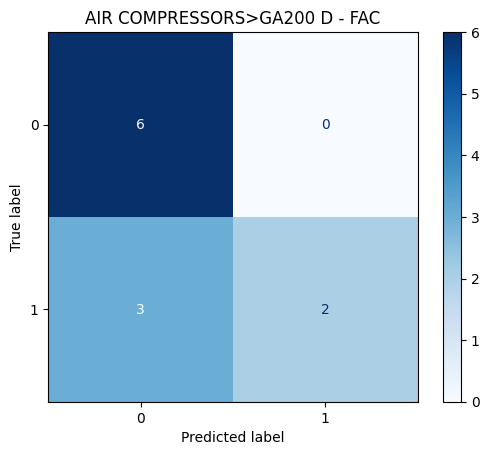

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR LINE 2 ║
╚══════════════════════════════╝
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

AUC-ROC Score: 1.0


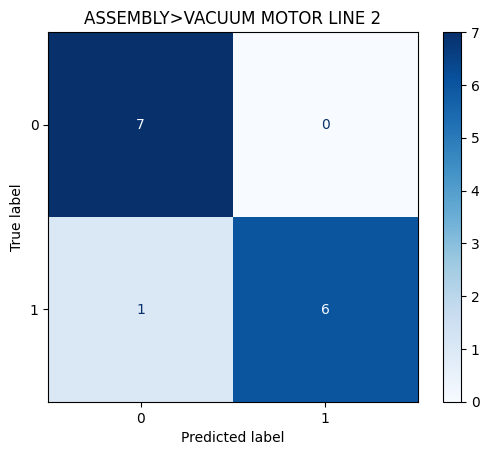

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR LINE 3 ║
╚══════════════════════════════╝
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.67      0.80         6

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13

AUC-ROC Score: 1.0


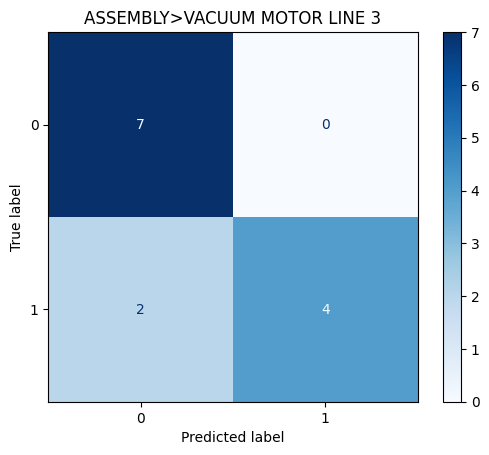

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR L17 DC ║
╚══════════════════════════════╝
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12

AUC-ROC Score: 1.0


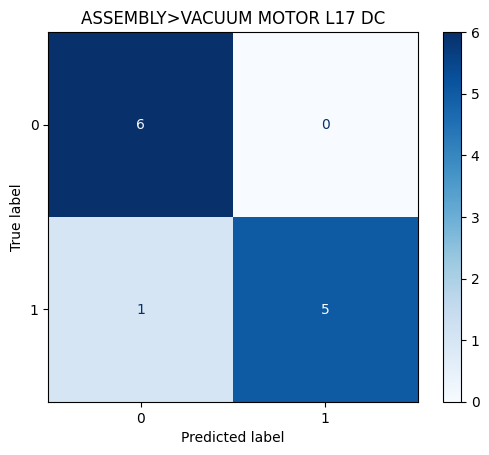

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

# Iterate through the X_train, X_test, y_train, and y_test of each machine
for machine_name, data_dict in train_test_data.items():

    # Declare X_train, X_test, y_train, y_test
    X_train = data_dict['X_train'].drop('synthetic?', axis=1)
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Base Model 1 - RandomForestClassifier
    # Base Model 2 - SVC
    estimator_list = [
        ('RandomForestClassifier', RandomForestClassifier(random_state=42, n_estimators=10)),
        ('SVC', SVC(random_state=42))
    ]

    # StackingClassifier Instance
    # Meta Model - MLPClassifier
    stack_model = StackingClassifier(
        estimators = estimator_list,
        final_estimator = MLPClassifier(random_state=42)
    )

    stack_model = stack_model.fit(X_train_scaled, y_train) # Fit
    predictions = stack_model.predict(X_test_scaled) # Predict
    predictions_probas = stack_model.predict_proba(X_test_scaled) # Prediction Probabilities

    # Metrics
    print_msg_box(machine_name)
    print(classification_report(y_test, predictions)) # Classification Report
    print(f"AUC-ROC Score: {roc_auc_score(y_test, predictions_probas[:, 1])}") # AUC-ROC Score

    ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues') # Confusion Matrix
    plt.title(f"{machine_name}")
    plt.show()

    print("="*100)

## With Hyperparameter Tuning

* The output here is already for the test results

╔═════════════════════════════════════════════╗
║ ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER ║
╚═════════════════════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'lbfgs', 'stacking_classifier_model__final_estimator__learning_rate': 'adaptive', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (50,), 'stacking_classifier_model__final_estimator__alpha': 0.0001, 'stacking_classifier_model__final_estimator__activation': 'tanh', 'stacking_classifier_model__SVC__gamma': 0.001, 'stacking_classifier_model__SVC__C': 10, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 200, 'stacking_classifier_model__RandomForestClassifier__max_features': 'sqrt', 'scaler': StandardScaler()}
ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                  

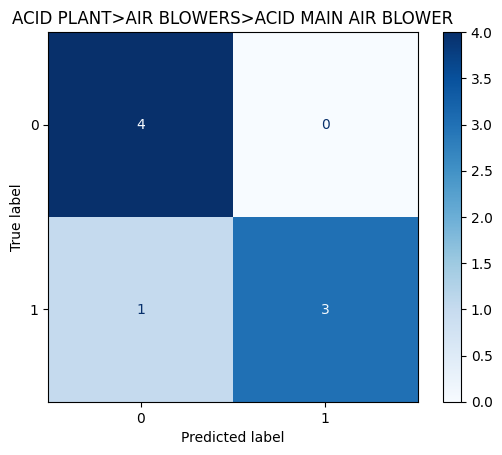

╔═════════════════════════════════════════════════════╗
║ ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B ║
╚═════════════════════════════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'lbfgs', 'stacking_classifier_model__final_estimator__learning_rate': 'constant', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (100,), 'stacking_classifier_model__final_estimator__alpha': 0.01, 'stacking_classifier_model__final_estimator__activation': 'logistic', 'stacking_classifier_model__SVC__gamma': 100, 'stacking_classifier_model__SVC__C': 10, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 10, 'stacking_classifier_model__RandomForestClassifier__max_features': 2, 'scaler': StandardScaler()}
ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

   

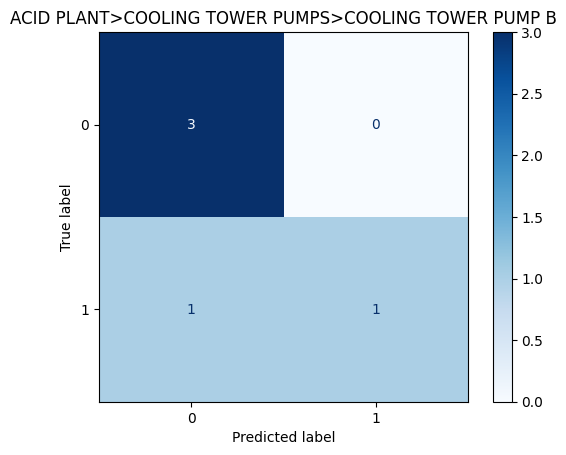

╔════════════════════════════════════════════╗
║ AIR COMPRESSORS>GA132 - FAC>Main Air Comp. ║
╚════════════════════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'adam', 'stacking_classifier_model__final_estimator__learning_rate': 'adaptive', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (100,), 'stacking_classifier_model__final_estimator__alpha': 0.01, 'stacking_classifier_model__final_estimator__activation': 'logistic', 'stacking_classifier_model__SVC__gamma': 10, 'stacking_classifier_model__SVC__C': 0.1, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 50, 'stacking_classifier_model__RandomForestClassifier__max_features': 'sqrt', 'scaler': MinMaxScaler()}
AIR COMPRESSORS>GA132 - FAC>Main Air Comp.
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

    accuracy                         

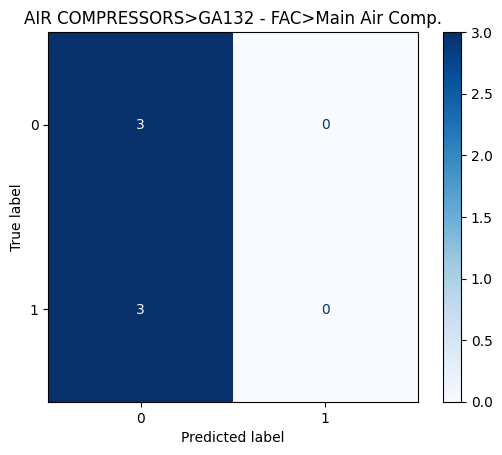

╔═══════════════════════════════╗
║ AIR COMPRESSORS>GA200 D - FAC ║
╚═══════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'adam', 'stacking_classifier_model__final_estimator__learning_rate': 'constant', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (100, 50), 'stacking_classifier_model__final_estimator__alpha': 0.001, 'stacking_classifier_model__final_estimator__activation': 'tanh', 'stacking_classifier_model__SVC__gamma': 0.1, 'stacking_classifier_model__SVC__C': 0.01, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 125, 'stacking_classifier_model__RandomForestClassifier__max_features': 'sqrt', 'scaler': MinMaxScaler()}
AIR COMPRESSORS>GA200 D - FAC
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.6

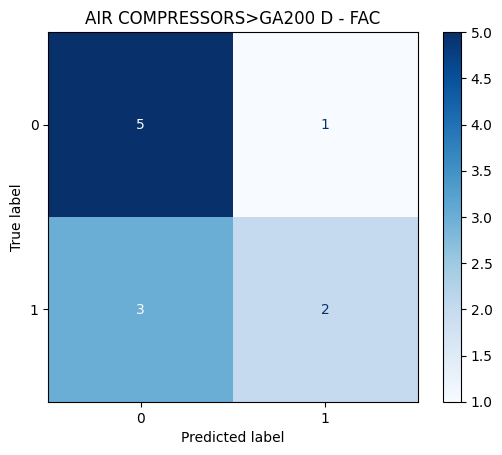

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR LINE 2 ║
╚══════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'sgd', 'stacking_classifier_model__final_estimator__learning_rate': 'constant', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (50, 50), 'stacking_classifier_model__final_estimator__alpha': 0.0001, 'stacking_classifier_model__final_estimator__activation': 'relu', 'stacking_classifier_model__SVC__gamma': 'scale', 'stacking_classifier_model__SVC__C': 0.1, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 100, 'stacking_classifier_model__RandomForestClassifier__max_features': 1, 'scaler': MinMaxScaler()}
ASSEMBLY>VACUUM MOTOR LINE 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      

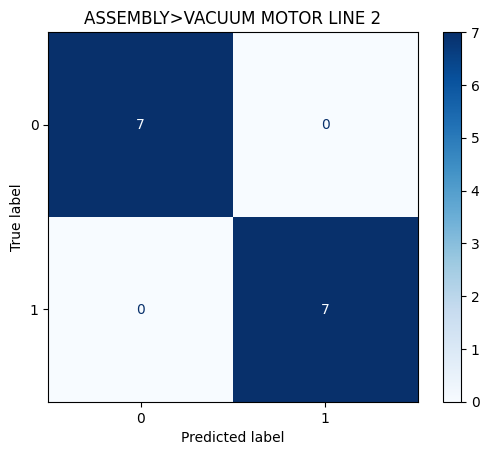

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR LINE 3 ║
╚══════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'adam', 'stacking_classifier_model__final_estimator__learning_rate': 'constant', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (100,), 'stacking_classifier_model__final_estimator__alpha': 0.01, 'stacking_classifier_model__final_estimator__activation': 'logistic', 'stacking_classifier_model__SVC__gamma': 'scale', 'stacking_classifier_model__SVC__C': 0.01, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 50, 'stacking_classifier_model__RandomForestClassifier__max_features': 3, 'scaler': MinMaxScaler()}
ASSEMBLY>VACUUM MOTOR LINE 3
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.50      0.67         6

    accuracy                           0.77        13
   macro avg       0.85      0.75     

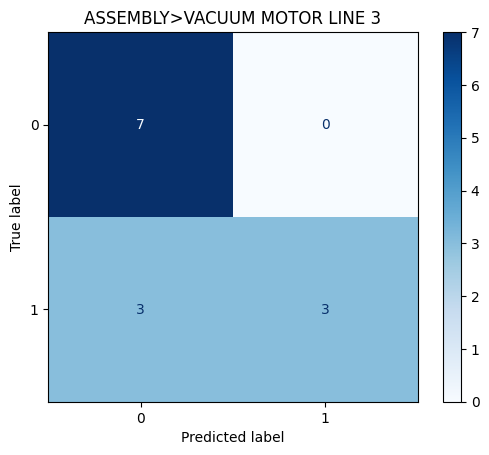

╔══════════════════════════════╗
║ ASSEMBLY>VACUUM MOTOR L17 DC ║
╚══════════════════════════════╝
Best Parameters: {'stacking_classifier_model__final_estimator__solver': 'sgd', 'stacking_classifier_model__final_estimator__learning_rate': 'constant', 'stacking_classifier_model__final_estimator__hidden_layer_sizes': (100, 50), 'stacking_classifier_model__final_estimator__alpha': 0.0001, 'stacking_classifier_model__final_estimator__activation': 'tanh', 'stacking_classifier_model__SVC__gamma': 10, 'stacking_classifier_model__SVC__C': 10, 'stacking_classifier_model__RandomForestClassifier__n_estimators': 10, 'stacking_classifier_model__RandomForestClassifier__max_features': 'log2', 'scaler': MinMaxScaler()}
ASSEMBLY>VACUUM MOTOR L17 DC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1

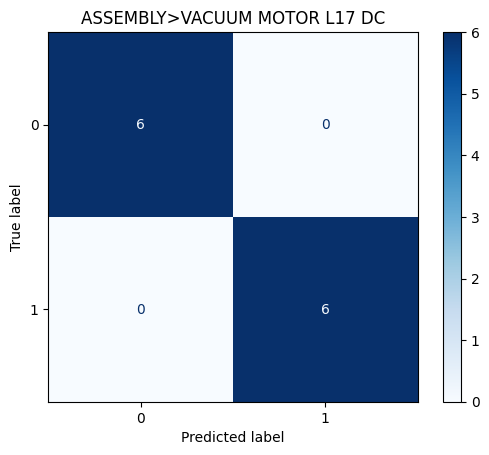

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Iterate through the X_train, X_test, y_train, and y_test of each machine
for machine_name, data_dict in train_test_data.items():

    # Declare X_train, X_test, y_train, and y_test
    X_train = data_dict['X_train'].drop('synthetic?', axis=1)
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']

    # # Scaling
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # Base Model 1 - RandomForestClassifier
    # Base Model 2 - SVC
    estimator_list = [
        ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
        ('SVC', SVC(random_state=42))
    ]

    # StackingClassifier Instance
    # Meta Model - MLPClassifier
    stack_model = StackingClassifier(
        estimators = estimator_list,
        final_estimator = MLPClassifier(random_state=42)
    )

    pipeline = Pipeline([
        ('scaler', ColumnTransformer(transformers=[('numeric', StandardScaler(), X_train.columns)], remainder='passthrough')),
        ('stacking_classifier_model', stack_model)
    ])

    # Param Grid/Distributions for Hyperparameter Tuning
    param_grid = {
        'scaler': [StandardScaler(), MinMaxScaler()], # Scalers
        'stacking_classifier_model__RandomForestClassifier__max_features' : ['sqrt', 'log2', 1, 2, 3], # Base Model 1
        'stacking_classifier_model__RandomForestClassifier__n_estimators' : [10, 50, 100, 125, 200],
        'stacking_classifier_model__SVC__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10, 100], # Base Model 2
        'stacking_classifier_model__SVC__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'stacking_classifier_model__final_estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # Meta Model
        'stacking_classifier_model__final_estimator__activation': ['relu', 'logistic', 'tanh'],
        'stacking_classifier_model__final_estimator__solver': ['adam', 'sgd', 'lbfgs'],
        'stacking_classifier_model__final_estimator__alpha': [0.0001, 0.001, 0.01],
        'stacking_classifier_model__final_estimator__learning_rate': ['constant', 'adaptive']
    }

    # Use RandomizedSearchCV to make it faster
    grid = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, cv=5)

    # Fitting to get the best parameter values
    grid = grid.fit(X_train, y_train)
    best_params = grid.best_params_
    print_msg_box(machine_name)
    print(f"Best Parameters: {best_params}")
    pipeline.set_params(**best_params) # Set the best parameters as the current parameters
    stack_model = pipeline.fit(X_train, y_train) # Fit the stacking model classifier with the best parameters set

    path = os.path.join(r'D:\current_progress_07-24-2023 -version2\trained_models\stacked_models')
    os.makedirs(path, exist_ok=True)
    filename = machine_name.replace('>', '_').replace(' ', '-')
    joblib.dump(stack_model, os.path.join(path, f'{filename}.pkl'))

    # Predictions
    predictions = pipeline.predict(X_test)
    predictions_probas = pipeline.predict_proba(X_test)

    # Metrics
    print(machine_name)
    print(classification_report(y_test, predictions))
    print(f"AUC-ROC Score: {roc_auc_score(y_test, predictions_probas[:, 1])}")

    ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues')
    plt.title(f"{machine_name}")
    plt.show()

    print("="*100)

## Getting other metrics for Training Results

Use the best performing model per machine with their best hyperparameters for this step
* Note: The best performing models are based on the results (from the Test Data) of confusion matrix with the least number of false predictions especially for Not Normal class and accuracy then AUC-ROC score to further support the judgement.

In [ ]:
machines_to_consider

['ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER',
 'ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B',
 'AIR COMPRESSORS>GA132 - FAC>Main Air Comp.',
 'AIR COMPRESSORS>GA200 D - FAC',
 'ASSEMBLY>VACUUM MOTOR LINE 2',
 'ASSEMBLY>VACUUM MOTOR LINE 3',
 'ASSEMBLY>VACUUM MOTOR L17 DC']

In [ ]:
# Filepaths of each PKL model (best) with their best hyperparameters from the previous section
amab = r'D:\vibration_analysis\for_model_maintenance\saved_models\ACID PLANT,AIR BLOWERS,ACID MAIN AIR BLOWER.pkl'
ct_pump_b = r'D:\vibration_analysis\for_model_maintenance\saved_models\ACID PLANT,COOLING TOWER PUMPS,COOLING TOWER PUMP B.pkl'
ga132 = r'D:\vibration_analysis\for_model_maintenance\saved_models\AIR COMPRESSORS,GA132 - FAC,Main Air Comp..pkl'
ga200d = r'D:\vibration_analysis\for_model_maintenance\saved_models\AIR COMPRESSORS,GA200 D - FAC.pkl'
line17 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR L17 DC.pkl'
line2 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR LINE 2.pkl'
line3 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR LINE 3.pkl'

In [ ]:
# Create a dictionary of machine names and filepaths as K,V pair
model_files = [amab, ct_pump_b, ga132, ga200d, line2, line3, line17]
machines_models_dict = dict(zip(machines_to_consider, model_files))

In [ ]:
# Sample Stacked Model Pipeline (w/ Scaler) - For ACID MAIN AIR BLOWER
joblib.load(machines_models_dict['ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('stacking_classifier_model',
                 StackingClassifier(estimators=[('RandomForestClassifier',
                                                 RandomForestClassifier(n_estimators=200,
                                                                        random_state=42)),
                                                ('SVC',
                                                 SVC(C=10, gamma=0.001,
                                                     random_state=42))],
                                    final_estimator=MLPClassifier(activation='tanh',
                                                                  hidden_layer_sizes=(50,),
                                                                  learning_rate='adaptive',
                                                                  random_state=42,
                                                                  solver='lbfgs')))])

In [ ]:
# Function for generating predictions (threshold adjustable)
def predict_alert_level_binary(pipeline, input_df, threshold=0.5):
    class_names = ['Normal', 'Not Normal']
    prediction_probas = pipeline.predict_proba(input_df)
    predictions = [class_names[0] if x[0] >= threshold else class_names[1] for x in prediction_probas]
    return predictions, prediction_probas[:, 1]

╔══════════════════════════════════════════════════════════════════╗
║ Training Results for ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER ║
╚══════════════════════════════════════════════════════════════════╝


              precision    recall  f1-score   support

           0       0.99      0.99      0.99        73
           1       0.99      0.99      0.99        73

    accuracy                           0.99       146
   macro avg       0.99      0.99      0.99       146
weighted avg       0.99      0.99      0.99       146

AUC-ROC Score: 0.9990617376618502


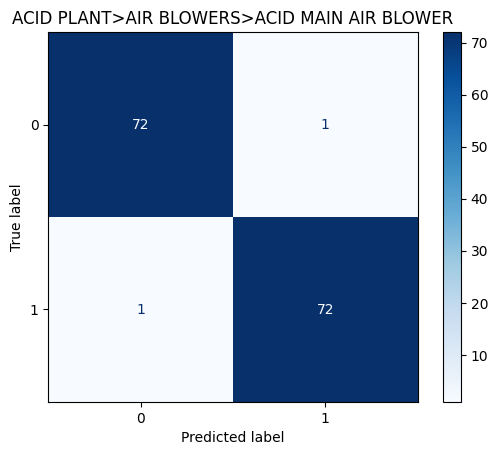

╔══════════════════════════════════════════════════════════════════════════╗
║ Training Results for ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B ║
╚══════════════════════════════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

AUC-ROC Score: 1.0


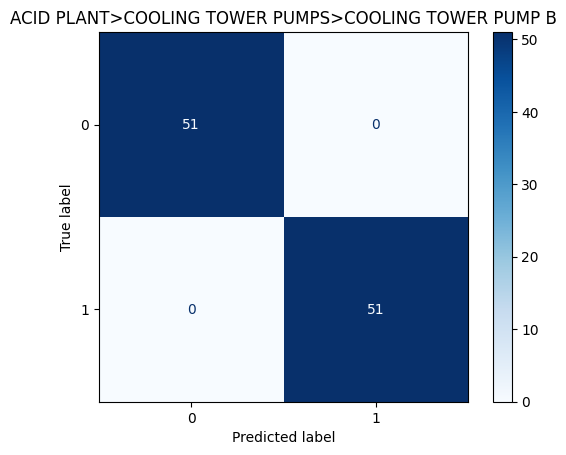

╔═════════════════════════════════════════════════════════════════╗
║ Training Results for AIR COMPRESSORS>GA132 - FAC>Main Air Comp. ║
╚═════════════════════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

AUC-ROC Score: 1.0


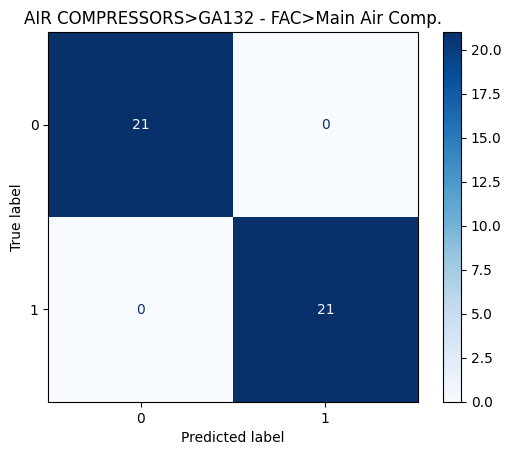

╔════════════════════════════════════════════════════╗
║ Training Results for AIR COMPRESSORS>GA200 D - FAC ║
╚════════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28

AUC-ROC Score: 1.0


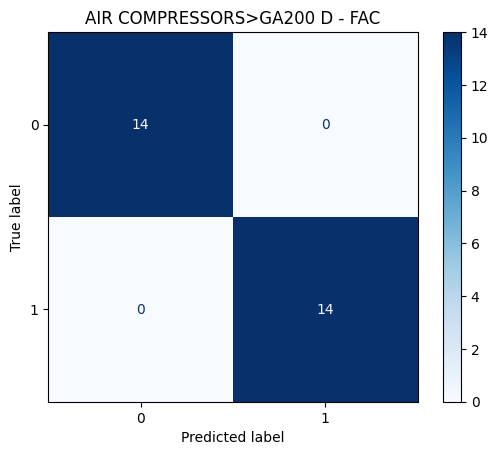

╔═══════════════════════════════════════════════════╗
║ Training Results for ASSEMBLY>VACUUM MOTOR LINE 2 ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

AUC-ROC Score: 1.0


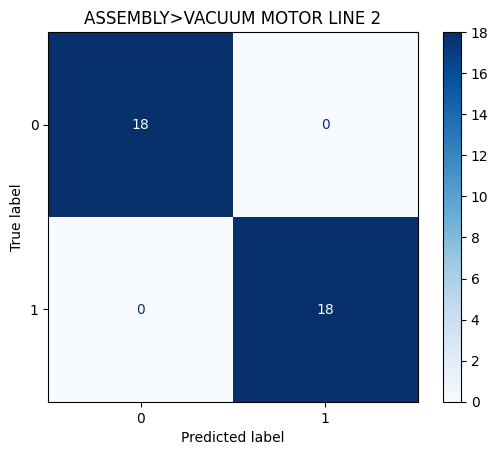

╔═══════════════════════════════════════════════════╗
║ Training Results for ASSEMBLY>VACUUM MOTOR LINE 3 ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        19

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

AUC-ROC Score: 1.0


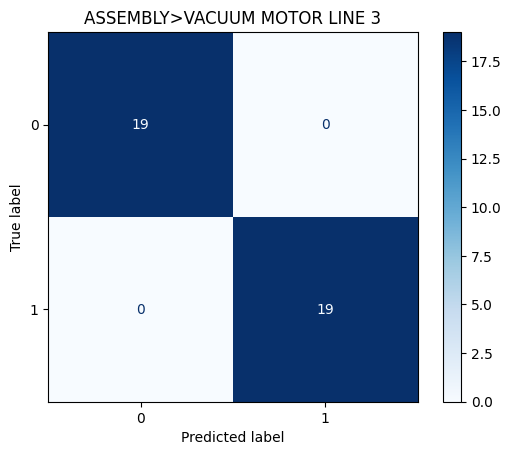

╔═══════════════════════════════════════════════════╗
║ Training Results for ASSEMBLY>VACUUM MOTOR L17 DC ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

AUC-ROC Score: 1.0


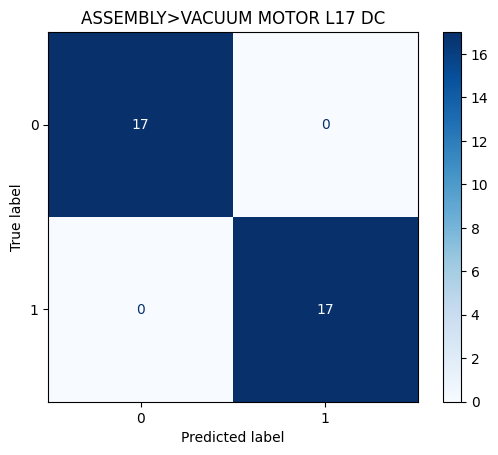

In [ ]:
# Iterate through each K,V pair then provide metrics for using X_train and y_train to get the training results
# Note that the supports have synthetic data on them compared to the test data used that had no synthetic data
for machine, files in machines_models_dict.items():
    X_train = train_test_data[machine]['X_train'].drop('synthetic?', axis=1)
    y_train = train_test_data[machine]['y_train']

    print_msg_box(f'Training Results for {machine}')
    pipeline = joblib.load(machines_models_dict[machine])
    predictions, prediction_probas = predict_alert_level_binary(pipeline, X_train)
    predictions = [0 if x=='Normal' else 1 for x in predictions]
    print(classification_report(y_train, predictions))
    print(f"AUC-ROC Score: {roc_auc_score(y_train, prediction_probas)}")
    ConfusionMatrixDisplay.from_predictions(y_train, predictions, cmap='Blues') # Confusion Matrix
    plt.title(f'{machine}')
    plt.show()

    print("="*100)

# Predicting new records from June to May

In [ ]:
jm_df = pd.read_csv(r'D:\current_progress_07-24-2023 -version2\data\june-may-records-preprocessed.csv')

In [ ]:
def filter_by_machine_name(df, machine_name):
    filt = (df['Machine Name'] == machine_name)
    return df[filt]

In [ ]:
# Function for generating predictions (threshold adjustable)
def predict_alert_level_binary(pipeline, input_df, threshold=0.5):
    class_names = ['Normal', 'Not Normal']
    prediction_probas = pipeline.predict_proba(input_df)
    predictions = [class_names[0] if x[0] >= threshold else class_names[1] for x in prediction_probas]
    return predictions, prediction_probas[:, 1]

In [ ]:
# Filepaths of each PKL model (best) with their best hyperparameters from the previous section
amab = r'D:\vibration_analysis\for_model_maintenance\saved_models\ACID PLANT,AIR BLOWERS,ACID MAIN AIR BLOWER.pkl'
ct_pump_b = r'D:\vibration_analysis\for_model_maintenance\saved_models\ACID PLANT,COOLING TOWER PUMPS,COOLING TOWER PUMP B.pkl'
ga132 = r'D:\vibration_analysis\for_model_maintenance\saved_models\AIR COMPRESSORS,GA132 - FAC,Main Air Comp..pkl'
ga200d = r'D:\vibration_analysis\for_model_maintenance\saved_models\AIR COMPRESSORS,GA200 D - FAC.pkl'
line17 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR L17 DC.pkl'
line2 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR LINE 2.pkl'
line3 = r'D:\vibration_analysis\for_model_maintenance\saved_models\ASSEMBLY,VACUUM MOTORS,VACUUM MOTOR LINE 3.pkl'

In [ ]:
model_filepaths = [
    line2, line3, ga200d, ga132, ct_pump_b, amab
]

In [ ]:
machine_name_model_fpaths = dict(zip(jm_df['Machine Name'].unique(), model_filepaths))

In [ ]:
jm_df['Machine Name'].unique()

array(['ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 2',
       'ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 3',
       'AIR COMPRESSORS>GA200 D - FAC',
       'AIR COMPRESSORS>GA132 - FAC>Main Air Comp.',
       'ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER PUMP B',
       'ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER'], dtype=object)

In [ ]:
machine_name_dts_preds = pd.DataFrame(columns=['Machine Name', 'DTS', 'Prediction'])
for machine_name, model_filepath in machine_name_model_fpaths.items():
    input_df = filter_by_machine_name(jm_df, machine_name)
    df_with_machine_name_and_dts = input_df.copy()
    input_df = input_df.drop(['Machine Name', 'DTS'], axis=1)
    input_df = input_df.dropna(axis=1, how='all')

    model = joblib.load(model_filepath)
    input_df = input_df[model.feature_names_in_]
    # predictions, _ = predict_alert_level_binary(model, input_df, 0.5)
    predictions = model.predict(input_df)
    df_with_machine_name_and_dts['Prediction'] = predictions
    machine_name_dts_preds =  pd.concat([machine_name_dts_preds, df_with_machine_name_and_dts[['Machine Name', 'DTS', 'Prediction']]], axis=0)

In [ ]:
jm_df.merge(machine_name_dts_preds, on=['Machine Name', 'DTS']).sort_values(by=['Machine Name', 'DTS'])

,Machine Name,DTS,1AV_overall_trend,1HE_overall_trend,1HV_overall_trend,1VV_overall_trend,2AV_overall_trend,2HE_overall_trend,2HV_overall_trend,2VV_overall_trend,...,3HE_overall_trend,3HV_overall_trend,3VV_overall_trend,4AV_overall_trend,4HE_overall_trend,4HV_overall_trend,4VV_overall_trend,5HE_overall_trend,6HE_overall_trend,Prediction
8,ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER,6/30/2023,0.241653,9.759514,1.171224,0.726493,0.205466,6.400342,0.578402,0.858638,...,8.413037,6.013672,2.998596,1.566363,2.574236,2.308725,1.932737,NaN,NaN,1
7,ACID PLANT>COOLING TOWER PUMPS>COOLING TOWER P...,6/30/2023,1.054872,1.486374,2.449034,1.257744,2.525712,2.265389,3.303629,1.941740,...,2.583697,2.499619,1.590930,1.118503,2.093570,1.625950,1.145436,NaN,NaN,0
6,AIR COMPRESSORS>GA132 - FAC>Main Air Comp.,6/13/2023,4.720603,9.786370,5.519654,7.292398,4.691000,4.357891,3.306986,3.486129,...,11.852170,NaN,NaN,NaN,9.983520,NaN,NaN,9.532762,7.854244,0
5,AIR COMPRESSORS>GA200 D - FAC,6/27/2023,5.778298,3.569903,2.237617,5.404065,1.753746,6.155278,2.583087,8.170186,...,10.287790,NaN,NaN,NaN,6.736351,NaN,NaN,6.878567,5.208289,1
4,AIR COMPRESSORS>GA200 D - FAC,7/13/2023,4.618671,4.947051,1.093745,5.455184,1.303064,4.841304,1.700568,7.289728,...,9.291970,NaN,NaN,NaN,7.650990,NaN,NaN,11.499370,7.588733,0
1,ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 2,6/5/2023,3.429212,2.105777,5.905713,3.991363,3.221686,2.641682,4.343699,3.140965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
0,ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 2,7/4/2023,2.553941,3.307443,2.940306,3.646504,2.706992,3.104495,4.198431,4.109928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 3,6/5/2023,1.951735,1.101962,4.557940,4.250923,1.605731,2.022309,3.367718,5.873669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,ASSEMBLY>VACUUM MOTORS>VACUUM MOTOR LINE 3,7/4/2023,1.801889,1.372234,5.363246,4.650411,1.686148,1.931333,3.578753,5.808817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
save_path = r'D:\current_progress_07-24-2023 -version2\data\june-may-records-preprocessed-predictions.csv'
jm_df.merge(machine_name_dts_preds, on=['Machine Name', 'DTS']).sort_values(by=['Machine Name', 'DTS']).to_csv(save_path, index=False)

## Saving and Loading/Parsing the train_test_data dictionary with synthetic records

In [ ]:
train_test_data_copy = train_test_data.copy()

In [ ]:
train_test_data_copy['ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER']['X_train'] = pd.DataFrame(train_test_data_copy['ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER']['X_train'])

In [ ]:
for key, value in train_test_data_copy.items():
    value['X_train'] = value['X_train'].to_dict(orient='records')
    value['X_test'] = value['X_test'].to_dict(orient='records')
    value['y_train'] = value['y_train'].to_list()
    value['y_test'] = value['y_test'].to_list()

In [ ]:
import json

# Save train_test_data as JSON file (with synthetic train records)
with open('train_test_data.json', "w") as json_file:
    json.dump(train_test_data_copy, json_file, indent=4)

print(f"Data has been successfully")

Data has been successfully


In [ ]:
# Reading/Parsing
with open('train_test_data.json', "r") as json_file:
    json_data = json.load(json_file)

In [ ]:
pd.DataFrame(json_data['ACID PLANT>AIR BLOWERS>ACID MAIN AIR BLOWER']['X_test'])

,1HE_overall_trend,1HV_overall_trend,1VV_overall_trend,1AV_overall_trend,2HE_overall_trend,2HV_overall_trend,2VV_overall_trend,2AV_overall_trend,3HE_overall_trend,3HV_overall_trend,3VV_overall_trend,3AV_overall_trend,4HE_overall_trend,4HV_overall_trend,4VV_overall_trend,4AV_overall_trend
0,4.892422,0.753578,0.780816,0.680372,4.252754,1.092563,0.390545,0.741752,2.580187,2.566607,1.623814,2.421339,2.092959,2.204504,1.611606,1.591388
1,0.909269,0.703681,3.900571,0.442122,1.166112,1.651433,1.205214,0.885304,2.211066,2.155370,2.859584,1.612293,2.111270,1.898938,3.810236,2.664876
2,5.496078,0.793329,0.544488,0.494675,3.292184,1.190909,0.447844,0.489059,2.892544,3.483688,1.846828,1.520127,2.312387,2.295450,2.052522,1.969970
3,5.918149,0.825488,3.953825,2.387005,3.192541,3.693808,3.700675,2.820521,3.125095,9.990616,5.998795,2.808008,1.951964,5.988113,10.627690,3.960082
4,4.793848,1.783731,4.166387,1.410947,6.462600,3.131962,3.688162,1.236801,1.495590,6.505402,3.898129,1.896649,1.820429,5.597095,5.975524,2.500076
5,1.248573,0.377880,0.555170,0.776353,0.581378,1.265908,0.637684,0.790239,3.782464,3.170721,4.501175,1.622059,4.320506,3.036592,2.708976,1.624805
6,7.779473,3.709372,11.134300,9.769738,3.426618,4.109012,16.105380,9.371853,4.769890,8.702734,6.906339,6.654180,2.638630,3.990753,18.156220,7.858135
7,8.235420,2.653890,1.810892,0.926580,3.914151,0.573862,0.955382,0.198279,3.579821,3.619037,3.559832,4.170354,2.583697,2.234870,2.141865,1.481521
